In [1]:
import tensorflow_addons as tfa

In [8]:
import keras as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [9]:
def import_data():

    ds,info = tfds.load('oxford_iiit_pet', split='all',with_info=True)
    ds_train = ds.skip(300)
    ds_test = ds.take(300)
    return ds_train,ds_test,info

In [10]:
ds_train_raw,ds_test_raw,info = import_data()

In [11]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float64)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))

    seg_image = tf.cast(seg_image, tf.uint8)
    seg_image = seg_image % 2
    seg_image = tf.cast(seg_image, tf.float64)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)
resize_test = ds_test_raw.map(pre_process_image)

In [13]:
img_inputs = K.Input(shape=next(iter(resize_train))[0].shape)

In [14]:
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x = K.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = K.layers.Dropout(dropout)(x)
    return x

In [15]:
class Patches(K.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [16]:
patch_size=10

Image size: 128 X 128
Patch size: 10 X 10
Patches per image: 144
Elements per patch: 300


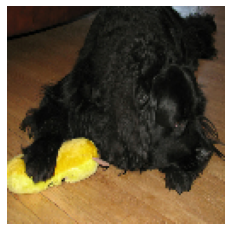

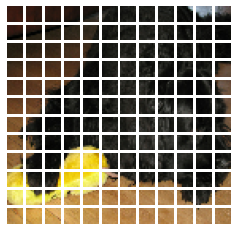

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = next(iter(resize_train.take(8)))
plt.imshow(image[0])
plt.axis("off")

patches = Patches(patch_size)([image[0]])
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.axis("off")

In [22]:
class PatchEncoder(K.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = K.layers.Dense(units=projection_dim)
        self.position_embedding = K.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100

input_shape = next(iter(resize_train))[0].shape
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_heads = 4

In [26]:
input_shape

TensorShape([128, 128, 3])

In [27]:
segshape=[128,128,1]

In [28]:
def im2seg_transformer():
    inputs = K.layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = K.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = K.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = K.layers.Add()([attention_output, encoded_patches])
        x3 = K.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        encoded_patches = K.layers.Add()([x3, x2])

    representation = K.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = K.layers.Flatten()(representation)
    representation = K.layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    output = K.layers.Dense(np.prod(segshape), activation="sigmoid")(features)
    output = tf.reshape(output,(-1,128,128,1))
    # Create the Keras model.
    model = K.Model(inputs=inputs, outputs=output,)
    return model

In [29]:
model = im2seg_transformer()

In [30]:
def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [31]:

callbacks = [
    K.callbacks.ModelCheckpoint("pet_autoencoder.h5", save_best_only=True, monitor="val_dice_coef",mode="max")
]

# Train the model, doing validation at the end of each epoch.
epochs = 60


optimizer = K.optimizers.rmsprop_v2.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=diceCoefLoss,metrics=[K.metrics.MeanIoU(num_classes=2),dice_coef])

In [33]:
ds_train = resize_train.batch(64).prefetch(tf.data.AUTOTUNE)
history = model.fit(ds_train,epochs=20)

Epoch 1/20
111/111 [==============================] - 208s 2s/step - loss: 0.3102 - mean_io_u: 0.5346 - dice_coef: 0.6903
Epoch 2/20
111/111 [==============================] - 211s 2s/step - loss: 0.3010 - mean_io_u: 0.5681 - dice_coef: 0.6994
Epoch 3/20
111/111 [==============================] - 211s 2s/step - loss: 0.3009 - mean_io_u: 0.5682 - dice_coef: 0.6996
Epoch 4/20
111/111 [==============================] - 212s 2s/step - loss: 0.3008 - mean_io_u: 0.5685 - dice_coef: 0.6996
Epoch 5/20
111/111 [==============================] - 218s 2s/step - loss: 0.3008 - mean_io_u: 0.5687 - dice_coef: 0.6996
Epoch 6/20
 67/111 [=================>............] - ETA: 1:26 - loss: 0.3015 - mean_io_u: 0.5684 - dice_coef: 0.6985

KeyboardInterrupt: 

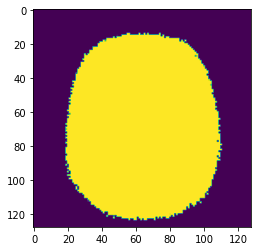

In [37]:
import matplotlib.pyplot as plt
plt.imshow(model(tf.reshape(next(iter(resize_train))[0],(-1,128,128,3)))[0])